In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gensim
from gensim.models import word2vec
import string
import re
random.seed(1)
np.random.seed(1)
import rpy2.robjects as r

In [2]:
os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
#os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

## Importation de word2vec

In [3]:
nom_dossier = 'ens'
dim = 100
epoch = 100
window = 4
learning_rate = 0.02

In [4]:
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

# Fonctions générales

In [5]:
# On traite la mise en forme comme dans notre corpus
def mise_en_forme_phrase (phrase):
    phrase = phrase.lower()
    # On enlève la ponctuation + certaines apostrophes
    phrase = phrase.translate(str.maketrans('', '', string.punctuation + "'’«»—"))
    # On enlève les passages à la ligne
    phrase = re.sub('\\n', ' ', phrase)
    # On enlève les tabulations
    phrase = re.sub('\\t', ' ', phrase)
    # On enlève les espaces multiples et les espaces à la fin des phrases
    phrase = re.sub(' +', ' ', phrase)
    phrase = re.sub(' +$', '', phrase)
    phrase = re.sub('^ +', '', phrase)
    # phrase.isalpha() # inutile
    return(phrase)

In [6]:
def calcul_sentence_embedding(phrase,lowfrequency_zero,pond=False):
    
    if len(phrase)>0: 
        if(pond): #Modèle de la fin non utilisé
            sum1 = sum(matrice[mot]*matrice_sentiments_val[mot] for mot in phrase if mot in model1.wv.index2word and
                   mot in vocabulaire)
            if lowfrequency_zero==False:
                sum2 = sum(matrice["lowfrequencyword"]*0 for mot in phrase if mot not in model1.wv.index2word)
                return (sum1+sum2)/len(phrase)
            else:
                return  (sum1)/(len([mot for mot in phrase if mot in model1.wv.index2word]))
        else:     
            sum1 = sum(matrice[mot] for mot in phrase if mot in model1.wv.index2word)
            #sum1 = sum(matrice_norm[mot] for mot in phrase if mot in model1.wv.index2word)
            if lowfrequency_zero==False:
                sum2 = sum(matrice["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
                #sum2 = sum(matrice_norm["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
                return (sum1+sum2)/len(phrase)
            else:
                taille = len([mot for mot in phrase if mot in model1.wv.index2word])
                if taille>0:
                    return  (sum1)/taille
                else: 
                    return 'NaN'
    else:
        if lowfrequency_zero==False:
            return matrice["lowfrequencyword"]
        else:
            return 'NaN'

In [7]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

In [8]:
def creer_indice(modeles,rmsws,mot_rares):
    
    resultat = pd.DataFrame(columns=[''])
    
    #fichiers des modeles
    #if(isinstance(modele, list)):
    #modele = r.r['paste0']("(",r.r['paste0']("(",modele,")",collapse = "|"),")")[0]
    #if(isinstance(rmsw, list)):
    #rmsw = r.r['paste0']("(",r.r['paste0']("(",rmsw,")",collapse = "|"),")")[0]
    #if(isinstance(mot_rare, list)):
    #mot_rare = r.r['paste0']("(",r.r['paste0']("(",mot_rare,")",collapse = "|"),")")[0]
    #requete_regexp = 'reg_{}_{}_{}'.format(modele,rmsw,mot_rare)
    #fichiers_modeles = r.r['list.files'](path = 'data/sentimental_analysis/',
    #                  pattern = requete_regexp)
    #requete_regexp = 'reg_{}_{}_{}'.format(modele,rmsw,mot_rare)
    
    #fichiers de tweets mensuels
    fichiers_tweets = []
    for i in range(2011,2019):
        for j in range(1,13): #range(1,13) normalement (là je fais tourner petit à petit car long)
            if j < 10:
                mot = "0"+str(j)
            else:
                mot = str(j)
            fichiers_tweets.append(str(str(i)+"-"+mot+"-"+mot))
    for modele in modeles:
        for rmsw in rmsws:
            for mot_rare in mot_rares:
                regression = 'reg_{}_{}_{}'.format(modele,rmsw,mot_rare)
                chemin = "data/sentimental_analysis/{}.file".format(regression)
                if mot_rare=="z":
                    lowfrequency_zero_bool = True
                else:
                    lowfrequency_zero_bool = False

                with open(chemin, "rb") as f:
                    reg  = pickle.load(f)
                resultat[regression] = 0
                print(regression)
                for nom in fichiers_tweets:
                    print(nom)
                    df = pd.read_csv("data/sentimental_analysis/tweet_filtered_trim/" + nom +"-trim-agg.txt",sep="#//#/?&",header=None,engine='python',encoding='UTF-8')
                    df.columns = ['tweet']
                    if rmsws=="rmsw":
                        phrases = [suppr_stop(mise_en_forme_phrase(ligne.tweet).split()) for ligne in df.itertuples()]
                    else:
                        phrases = [mise_en_forme_phrase(ligne.tweet).split() for ligne in df.itertuples()]
                    phrases_emb = [calcul_sentence_embedding(phrase,lowfrequency_zero=lowfrequency_zero_bool) for phrase in phrases]
                    phrases_emb = [phrase for phrase in phrases_emb if phrase != 'NaN']
                    Y = reg.predict(phrases_emb)
                    Y_bis = [max(val,0) for val in Y]
                    resultat.loc[nom[0:7],regression] = [np.mean(Y_bis)]
    return resultat

# Calcul des indices mensuels (étape à ne pas refaire ultérieurement)

In [11]:
resultat = creer_indice(modeles = ["log","prob"],rmsws = ["rmsw","nrmsw"],mot_rares = ["z","lf"])

['2011-02-02', '2011-03-03', '2012-02-02', '2012-03-03', '2013-02-02', '2013-03-03', '2014-02-02', '2014-03-03', '2015-02-02', '2015-03-03', '2016-02-02', '2016-03-03', '2017-02-02', '2017-03-03', '2018-02-02', '2018-03-03']


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


reg_log_rmsw_z
2011-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Kim Antunez\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


reg_log_rmsw_lf
2011-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-03-03
2012-02-02
2012-03-03
2013-02-02
2013-03-03
2014-02-02
2014-03-03
2015-02-02
2015-03-03
2016-02-02
2016-03-03
2017-02-02
2017-03-03
2018-02-02
2018-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


reg_log_nrmsw_z
2011-02-02
2011-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Kim Antunez\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


reg_log_nrmsw_lf
2011-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2012-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2013-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2014-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2015-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2016-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2017-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2018-03-03


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


reg_prob_rmsw_z
2011-02-02


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


2011-03-03
2012-02-02
2012-03-03
2013-02-02
2013-03-03
2014-02-02
2014-03-03
2015-02-02
2015-03-03
2016-02-02
2016-03-03
2017-02-02
2017-03-03
2018-02-02
2018-03-03
reg_prob_rmsw_lf
2011-02-02
2011-03-03
2012-02-02
2012-03-03
2013-02-02
2013-03-03
2014-02-02
2014-03-03
2015-02-02
2015-03-03
2016-02-02
2016-03-03
2017-02-02
2017-03-03
2018-02-02
2018-03-03
reg_prob_nrmsw_z
2011-02-02
2011-03-03
2012-02-02
2012-03-03
2013-02-02
2013-03-03
2014-02-02
2014-03-03
2015-02-02
2015-03-03
2016-02-02
2016-03-03
2017-02-02
2017-03-03
2018-02-02
2018-03-03
reg_prob_nrmsw_lf
2011-02-02
2011-03-03
2012-02-02
2012-03-03
2013-02-02
2013-03-03
2014-02-02
2014-03-03
2015-02-02
2015-03-03
2016-02-02
2016-03-03
2017-02-02
2017-03-03
2018-02-02
2018-03-03


In [29]:
# sauver en .file
#with open("data/sentimental_analysis/index_tot.file", "wb") as f:
#    pickle.dump(resultat, f, pickle.HIGHEST_PROTOCOL)

In [13]:
# sauver en csv
#resultat.to_csv("Sentiment_brut_modele.csv",sep=";")

In [12]:
resultat

,,reg_log_rmsw_z,reg_log_rmsw_lf,reg_log_nrmsw_z,reg_log_nrmsw_lf,reg_prob_rmsw_z,reg_prob_rmsw_lf,reg_prob_nrmsw_z,reg_prob_nrmsw_lf
2011-02,NaN,0.635833,0.549375,0.642405,0.681884,0.534393,0.549375,0.560757,0.580065
2011-03,NaN,0.627762,0.548686,0.630884,0.672736,0.533117,0.548686,0.556807,0.576949
2012-02,NaN,0.591311,0.537297,0.600382,0.646190,0.521143,0.537297,0.541528,0.562171
2012-03,NaN,0.606742,0.538610,0.607459,0.654286,0.521125,0.538610,0.539149,0.561684
2013-02,NaN,0.562246,0.522719,0.559140,0.605238,0.505732,0.522719,0.518998,0.541124
2013-03,NaN,0.544128,0.515727,0.555370,0.602619,0.497545,0.515727,0.509168,0.533144
2014-02,NaN,0.524731,0.505988,0.525926,0.563333,0.490734,0.505988,0.499672,0.519950
2014-03,NaN,0.509556,0.498991,0.518395,0.555000,0.485044,0.498991,0.494432,0.512925
2015-02,NaN,0.525509,0.505165,0.529820,0.570714,0.489740,0.505165,0.497909,0.518286
2015-03,NaN,0.542065,0.510514,0.542782,0.587857,0.494609,0.510514,0.507520,0.528415


# Indice mensuel avec la baseline

In [71]:
def calcul_sentence_embedding_baseline(tweet, matrice_sentiments_val):
    sum1 = sum(matrice_sentiments_val[mot] for mot in tweet if mot in matrice_sentiments_val.keys())
    sum2 = sum(1 for mot in tweet if mot in matrice_sentiments_val.keys())
    if sum2 > 0:
        return sum1/sum2
    else:
        return 0

In [81]:
with open("data/sentimental_analysis/matrice_sentiment_baseline_git.file", "rb") as f:
    matrice_sentiment_git = pickle.load(f)
with open("data/sentimental_analysis/matrice_sentiment_baseline_sncf.file", "rb") as f:
    matrice_sentiment_sncf = pickle.load(f)

In [82]:
def creation_indice_baseline():
    resultat = pd.DataFrame(columns=[''])
    fichiers_tweets = []
    for i in range(2011,2019):
        for j in range(1,13):
            if j < 10:
                mot = "0"+str(j)
            else:
                mot = str(j)
            fichiers_tweets.append(str(str(i)+"-"+mot+"-"+mot))
    matrice = {"git":matrice_sentiment_git,
              "sncf":matrice_sentiment_sncf}
    for val_mat in matrice.keys():
        for nom in fichiers_tweets:
            print(nom)
            df = pd.read_csv("data/sentimental_analysis/tweet_filtered_trim/" + nom +"-trim-agg.txt",sep="#//#/?&",header=None,engine='python',encoding='UTF-8')
            df.columns = ['tweet']
            phrases = [mise_en_forme_phrase(ligne.tweet).split() for ligne in df.itertuples()]
            phrases_emb = [calcul_sentence_embedding_baseline(phrase,matrice[val_mat]) for phrase in phrases]
            Y = [1 if val > -0.05 else 0 for val in phrases_emb]
            resultat.loc[nom[0:7],val_mat] = [np.mean(Y)]
    return resultat

In [83]:
res = creation_indice_baseline()

2011-01-01
2011-02-02
2011-03-03
2011-04-04
2011-05-05
2011-06-06
2011-07-07
2011-08-08
2011-09-09
2011-10-10
2011-11-11
2011-12-12
2012-01-01
2012-02-02
2012-03-03
2012-04-04
2012-05-05
2012-06-06
2012-07-07
2012-08-08
2012-09-09
2012-10-10
2012-11-11
2012-12-12
2013-01-01
2013-02-02
2013-03-03
2013-04-04
2013-05-05
2013-06-06
2013-07-07
2013-08-08
2013-09-09
2013-10-10
2013-11-11
2013-12-12
2014-01-01
2014-02-02
2014-03-03
2014-04-04
2014-05-05
2014-06-06
2014-07-07
2014-08-08
2014-09-09
2014-10-10
2014-11-11
2014-12-12
2015-01-01
2015-02-02
2015-03-03
2015-04-04
2015-05-05
2015-06-06
2015-07-07
2015-08-08
2015-09-09
2015-10-10
2015-11-11
2015-12-12
2016-01-01
2016-02-02
2016-03-03
2016-04-04
2016-05-05
2016-06-06
2016-07-07
2016-08-08
2016-09-09
2016-10-10
2016-11-11
2016-12-12
2017-01-01
2017-02-02
2017-03-03
2017-04-04
2017-05-05
2017-06-06
2017-07-07
2017-08-08
2017-09-09
2017-10-10
2017-11-11
2017-12-12
2018-01-01
2018-02-02
2018-03-03
2018-04-04
2018-05-05
2018-06-06
2018-07-07

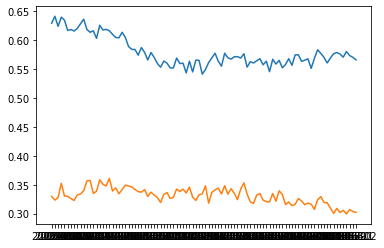

In [88]:
plt.plot(res['git'])
plt.plot(res['sncf'])

In [90]:
with open("data/sentimental_analysis/indice_baselines.file", "wb") as f:
    pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)